In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [25]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [26]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [27]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [28]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [29]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])   # Sequence of `seq_length`
        targets.append(data[i+seq_length])       # Next value as target
    
    return np.array(sequences), np.array(targets)

In [30]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[0:int(n*0.6)]
val_df1 = first_piece[int(n*0.8):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device='cuda') # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1).to(device='cuda')  # (batch, output_dim)


In [31]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device='cuda') # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2).to(device='cuda')  # (batch, output_dim)

In [32]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 = third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device='cuda') # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3).to(device='cuda')  # (batch, output_dim)

In [33]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 = fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device='cuda') # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4).to(device='cuda')  # (batch, output_dim)

In [34]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cuda")  # Use "cuda" if you have a GPU

model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)
criterion2 = nn.SmoothL1Loss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
criterion3 = nn.SmoothL1Loss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)

In [35]:
# Train model 1
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    y_pred = model1(train_seq_tensor1)
    
    loss = criterion1(y_pred, train_label_tensor1)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())

    # Validation
    model1.eval()
    with torch.no_grad():
        y_val = model1(val_seq_tensor1)
        val_loss = criterion1(y_val, val_label_tensor1)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.3699290454387665, Val Loss: 2.2212862968444824
Epoch 10, Train Loss: 0.36327263712882996, Val Loss: 2.1774260997772217
Epoch 20, Train Loss: 0.3506672978401184, Val Loss: 2.080307960510254
Epoch 30, Train Loss: 0.31846195459365845, Val Loss: 1.7936429977416992
Epoch 40, Train Loss: 0.27012377977371216, Val Loss: 1.1338552236557007
Epoch 50, Train Loss: 0.2509306073188782, Val Loss: 1.160110354423523
Epoch 60, Train Loss: 0.2272147238254547, Val Loss: 1.2291284799575806
Epoch 70, Train Loss: 0.19469955563545227, Val Loss: 1.1283186674118042
Epoch 80, Train Loss: 0.1489800065755844, Val Loss: 1.0810935497283936
Epoch 90, Train Loss: 0.08131580799818039, Val Loss: 0.8473678231239319
Epoch 100, Train Loss: 0.06508205831050873, Val Loss: 0.48166781663894653
Epoch 110, Train Loss: 0.05028514191508293, Val Loss: 0.3583298325538635
Epoch 120, Train Loss: 0.042989980429410934, Val Loss: 0.27005869150161743
Epoch 130, Train Loss: 0.037890758365392685, Val Loss: 0.239349380

In [36]:
# Train model 2

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer2.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion2(y_pred, train_label_tensor2)
    loss.backward()
    optimizer2.step()
    
    train_losses.append(loss.item())

    # Validation
    model2.eval()
    with torch.no_grad():
        y_val = model2(val_seq_tensor2)
        val_loss = criterion1(y_val, val_label_tensor2)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.44936707615852356, Val Loss: 1.5901308059692383
Epoch 10, Train Loss: 0.4372290372848511, Val Loss: 1.5174602270126343
Epoch 20, Train Loss: 0.4120396375656128, Val Loss: 1.4032872915267944
Epoch 30, Train Loss: 0.3365056812763214, Val Loss: 1.0853893756866455
Epoch 40, Train Loss: 0.1405792236328125, Val Loss: 0.12854821979999542
Epoch 50, Train Loss: 0.12492258101701736, Val Loss: 0.019944798201322556
Epoch 60, Train Loss: 0.1033000499010086, Val Loss: 0.04052319750189781
Epoch 70, Train Loss: 0.09672475606203079, Val Loss: 0.03763808310031891
Epoch 80, Train Loss: 0.09435111284255981, Val Loss: 0.03248124197125435
Epoch 90, Train Loss: 0.09070006012916565, Val Loss: 0.049420323222875595
Epoch 100, Train Loss: 0.08740934729576111, Val Loss: 0.0366191565990448
Epoch 110, Train Loss: 0.08408863097429276, Val Loss: 0.03582537919282913
Epoch 120, Train Loss: 0.08040633797645569, Val Loss: 0.03536241129040718
Epoch 130, Train Loss: 0.07621869444847107, Val Loss: 0.0

In [37]:
# Train model 3

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model3.train()
    
    optimizer3.zero_grad()
    y_pred = model3(train_seq_tensor3)
    
    loss = criterion3(y_pred, train_label_tensor3)
    loss.backward()
    optimizer3.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion3(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.43223804235458374, Val Loss: 0.6402450799942017
Epoch 10, Train Loss: 0.41940122842788696, Val Loss: 0.6854045987129211
Epoch 20, Train Loss: 0.396777868270874, Val Loss: 0.7093510031700134
Epoch 30, Train Loss: 0.33276036381721497, Val Loss: 0.6545771360397339
Epoch 40, Train Loss: 0.1923000067472458, Val Loss: 0.3020787835121155
Epoch 50, Train Loss: 0.15946374833583832, Val Loss: 0.021118367090821266
Epoch 60, Train Loss: 0.13628552854061127, Val Loss: 0.09856075048446655
Epoch 70, Train Loss: 0.12861551344394684, Val Loss: 0.10191939771175385
Epoch 80, Train Loss: 0.11952486634254456, Val Loss: 0.055547185242176056
Epoch 90, Train Loss: 0.1114080473780632, Val Loss: 0.07949681580066681
Epoch 100, Train Loss: 0.10338879376649857, Val Loss: 0.06274165958166122
Epoch 110, Train Loss: 0.09455125033855438, Val Loss: 0.0608924999833107
Epoch 120, Train Loss: 0.08435533195734024, Val Loss: 0.0537072978913784
Epoch 130, Train Loss: 0.07221446931362152, Val Loss: 0.04

In [38]:
# import copy
# # Average the models
# average_model = copy.deepcopy(model1)
# models = [model1, model2, model3]
# # Compute the average of the parameters
# with torch.no_grad():
#     for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
#         avg_param = sum(params) / len(models)  # Element-wise average
#         params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# # The `average_model` now has the averaged parameters

sd1 = model1.state_dict()
sd2 = model2.state_dict()
sd3 = model3.state_dict()
avg_model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
sd_avg = avg_model.state_dict()
for key in sd1:
    sd_avg[key] = (sd1[key] + sd2[key] + sd3[key])/3

avg_model.load_state_dict(sd_avg)
avg_model = avg_model.to(device='cuda')

In [39]:
# Normalize the data (each partition separately)
test_mean4 = (train_mean1 + train_mean2 + train_mean3 + train_mean4)/4
test_std = (train_std1 + train_std2 + train_std3 + train_std4)/4
test_df = fourth_piece
test_df = (test_df - test_mean4)/test_std

In [40]:
test_seq4, test_labels4 = create_sequences(test_df.values, 12)
test_tensor_seq4 = torch.FloatTensor(test_seq4).to(device='cuda')
test_tensor_labels4 = torch.FloatTensor(test_labels4).to(device='cuda')

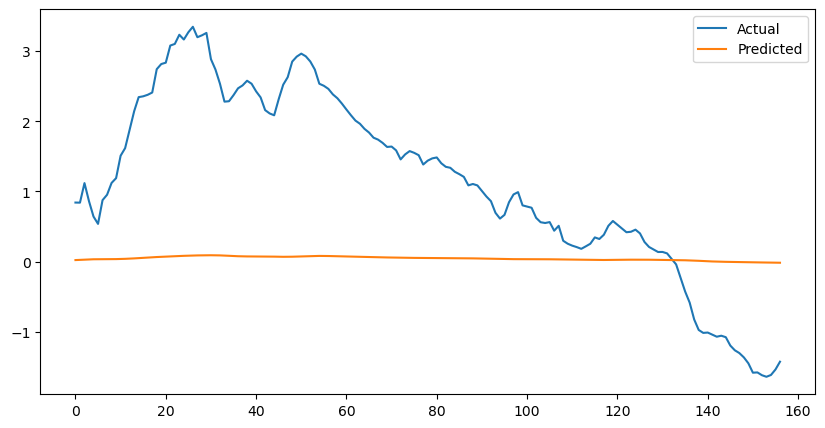

In [41]:
avg_model.eval()
with torch.no_grad():
    y_pred_test = avg_model(test_tensor_seq4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4.cpu().numpy(), label="Actual")
plt.plot(y_pred_test.cpu().numpy(), label="Predicted")
plt.legend()
plt.savefig('model123_avg_fl')

In [42]:
mae = criterion3(y_pred_test, test_tensor_labels4)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_tensor_labels4)}')

Mean Absolute Error: 0.9958735108375549
MARE: 0.96137934923172


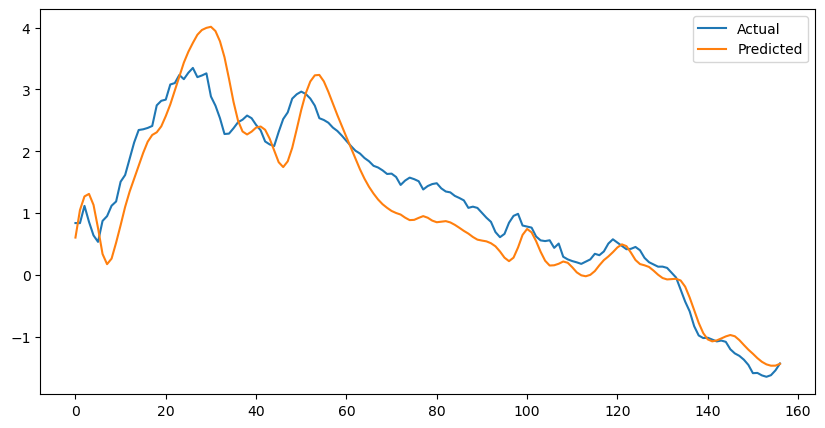

In [43]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_tensor_seq4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4.cpu().numpy(), label="Actual")
plt.plot(y_pred_test.cpu().numpy(), label="Predicted")
plt.legend()
plt.savefig('model123_avg_fl')

In [44]:
# # Sequence prediction
# average_model.eval()
# N_steps = 157
# window = test_tensor_seq4.clone()[0]
# predictions = []
# with torch.no_grad():
#     for _ in range(N_steps):
#         next_step_pred = average_model(window.unsqueeze(0))
#         # shift window by one
#         window = window[1:, :]
#         # append prediction
#         window = torch.cat((window, next_step_pred))
#         # print(next_step_pred.shape)
#         predictions.append(next_step_pred.squeeze(0))
    
# # Plot test predictions
# plt.figure(figsize=(10, 5))
# plt.plot(test_tensor_labels4.numpy()[:N_steps], label="Actual")
# plt.plot(predictions, label="Predicted")
# plt.legend()
# plt.savefig('small_seq_model123_avg_fl')        
